In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, classification_report

%matplotlib inline

# Initial Model

## In this notebook, we'll walk through building and tuning an initial random forest classification model. Later, we will improve on this by incorporating additional features extracted with Natural Language Processing (NLP) techniques, as well as utilizing a Bayesian optimizer for model selection and hyperparameter tuning. This model will serve as a baseline for comparing later versions. 

In [3]:
### Start by loading the refined dataset

data = pd.read_csv("data/clean_data.csv", index_col=0)
target = pd.read_csv('data/target.csv', index_col=0)

In [4]:
### We want to remove three columns in our loaded dataset, which were included for future use in NLP notebooks. 

data.drop(['clean_desc', 'lem_tokens','lem_text'], axis=1, inplace=True)

## Model Features

Using the python file *process_df*, we have already cleaned up the original data, extracted new features, and removed columns that won't work with our classification model (i.e. non-categorical text fields). 

Below is a list of the remaining feature names. For now, you can review the meanings of the original columns in the EDA notebook, and the meaning of the engineered columns in the *feature engineering* notebook. Later, I will be adding those explanations in this notebook for easier access. 

#### Categorical columns in original data: 
fb_published, analytics, logo, map, member_type, header,channels, listed, payout_method, currency, country, delivery_method
#### Engineered categorical columns:
desc_has_link, org_has_link, email_suffix_code, country_match
#### Continuous columns in original data: 
body_length, name_length, user_age, org_facebook, org_twitter, sale_duration
#### Engineered continuous columns
num_tiers, tickets_available, average_ticket_price, avg_previous_payouts, num_previous_payouts, org_desc_len, venue_name_len, org_name_len

### One hot encoding

In [6]:
df_one_hot = data.copy()

In [7]:
convert_cols = ['desc_has_link', 'org_has_link', 'email_suffix_code', 
            'country_match','fb_published', 'analytics', 'logo', 'map', 'member_type', 'header',
            'channels', 'listed', 'payout_method', 'currency', 'country', 'delivery_method']

In [8]:
df_one_hot = pd.get_dummies(data = df_one_hot, columns = convert_cols, prefix = convert_cols)

In [9]:
df_one_hot.shape

(14337, 148)

In [10]:
np.random.seed(33)
shuffle = np.random.choice( np.arange(len(data)), size=len(data), replace=False)

In [11]:
X = df_one_hot.iloc[shuffle]
y = target.fraud[shuffle]

# 14337 * 0.8 = 11469.6
X_train, X_test = X[:11470], X[11470:]
y_train, y_test = y[:11470], y[11470:]

In [12]:
rfc = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=47, class_weight='balanced')

In [13]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=True,
                       random_state=47, verbose=0, warm_start=False)

In [14]:
rfc.oob_score_

0.9858761987794246

In [36]:
y_hat = rfc.predict(X_test)
y_hat = pd.Series(y_hat, index=X_test.index)

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
tn, fp, fn, tp

(2582, 14, 20, 251)

In [38]:
target_names = ['not fraud', 'fraud']
print(classification_report(y_test, y_hat, target_names = target_names))

              precision    recall  f1-score   support

   not fraud       0.99      0.99      0.99      2596
       fraud       0.95      0.93      0.94       271

    accuracy                           0.99      2867
   macro avg       0.97      0.96      0.97      2867
weighted avg       0.99      0.99      0.99      2867



In [ ]:
import 

In [39]:
def actual_vs_predicted_counts(yhat, ytest):
    
    predicted_fraud = len(yhat[yhat == True])
    predicted_nf = len(yhat[yhat == False])

    actual_fraud = len(ytest[ytest == True])
    actual_nf = len(ytest[ytest == False])
    
    return predicted_fraud, predicted_nf, actual_fraud, actual_nf

In [81]:
predicted_fraud, predicted_nf, actual_fraud, actual_nf = actual_vs_predicted_counts(y_hat, y_test)

print(f'The test set includes {actual_nf} non-fraudulent events & {actual_fraud} fraudulent events.')
print(f'The model predicted {predicted_nf} non-fraudulent events & {predicted_fraud} fraudulent events.')

The test set includes 2596 non-fraudulent events & 271 fraudulent events.
The model predicted 2602 non-fraudulent events & 265 fraudulent events.


In [77]:
def result_sets(yhat, ytest):
    
    predicted_fraud = set(yhat[yhat == True].index)
    predicted_nf = set(yhat[yhat == False].index)

    actual_fraud = set(ytest[ytest == True].index)
    actual_nf = set(ytest[ytest == False].index)
    
    tp_set = predicted_fraud.intersection(actual_fraud)
    fp_set = predicted_fraud.intersection(actual_nf)
    tn_set = predicted_nf.intersection(actual_nf)
    fn_set = predicted_nf.intersection(actual_fraud)
    
    return tp_set, fp_set, tn_set, fn_set

In [78]:
tp_set, fp_set, tn_set, fn_set = result_sets(y_hat, y_test)

In [63]:
pred_prob_fraud[fp_set]
pred_prob_fraud[fn_set]

13569    0.086189
11650    0.309651
7554     0.010078
10000    0.141820
6691     0.361186
6441     0.493165
7082     0.286857
51       0.054039
1715     0.016841
5687     0.069654
9527     0.401644
1622     0.430845
11610    0.056026
7789     0.120950
11503    0.305106
11504    0.040685
1008     0.204888
755      0.431128
11764    0.389169
7541     0.077323
dtype: float64

In [70]:
(pred_prob_fraud[tp_set]>.8).sum()/(pred_prob_fraud[tp_set]).sum()

0.9378411533045301

In [72]:
(pred_prob_fraud[fp_set]>.8).sum()/len(pred_prob_fraud[fp_set])

0.21428571428571427

In [50]:
pred_prob = rfc.predict_proba(X_test)
pred_prob_fraud = pd.Series(pred_prob[:,1], index=X_test.index)

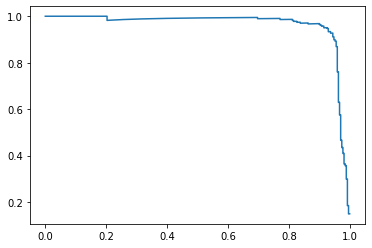

In [22]:
prc = precision_recall_curve(y_test, pred_prob[:,1], pos_label=True)
plt.plot(prc[1],
         prc[0]);

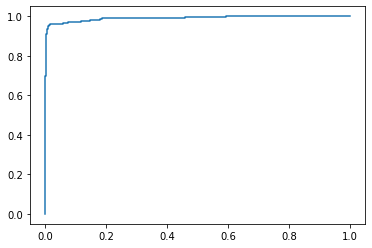

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1], pos_label=True)
plt.plot(fpr,tpr)
plt.show()

### Precision: Out of all events predicted to be fraud, what percent is actually fraud? 
tp / (tp + fp)

### Recall: Out of all fraudulent events, what percent were correctly identified by model?
tp / (tp + fn)

In [24]:
def fraud_precision(tp, fp):
    return tp/(tp+fp)

In [25]:
fraud_precision1 = fraud_precision(tp, fp)
fraud_precision1

0.9471698113207547

In [26]:
def fraud_recall(tp, fn):
    return tp / (tp + fn)

In [27]:
fraud_recall1 = fraud_recall(tp, fn)
fraud_recall1

0.9261992619926199

In [28]:
feat_imp = list(np.around(rfc.feature_importances_, 3))
feat_list = list(X_train.columns)

In [29]:
feat_imp_dict = {}
for t,r in zip(feat_list, feat_imp):
    feat_imp_dict[t] = r
feat_imp_dict

{'body_length': 0.03,
 'name_length': 0.012,
 'org_facebook': 0.046,
 'org_twitter': 0.023,
 'sale_duration': 0.1,
 'user_age': 0.069,
 'member_created': 0.029,
 'num_tiers': 0.006,
 'tickets_available': 0.01,
 'average_ticket_price': 0.023,
 'min_price': 0.021,
 'max_price': 0.019,
 'potential_revenue': 0.015,
 'org_desc_len': 0.008,
 'venue_name_len': 0.011,
 'org_name_len': 0.027,
 'avg_past_payouts': 0.16,
 'num_past_payouts': 0.168,
 'desc_has_link_False': 0.004,
 'desc_has_link_True': 0.006,
 'org_has_link_False': 0.001,
 'org_has_link_True': 0.002,
 'email_suffix_code_0': 0.002,
 'email_suffix_code_1': 0.002,
 'email_suffix_code_2': 0.003,
 'email_suffix_code_3': 0.0,
 'email_suffix_code_4': 0.0,
 'email_suffix_code_5': 0.0,
 'email_suffix_code_6': 0.0,
 'email_suffix_code_7': 0.002,
 'email_suffix_code_8': 0.0,
 'email_suffix_code_9': 0.0,
 'country_match_False': 0.009,
 'country_match_True': 0.01,
 'fb_published_0': 0.002,
 'fb_published_1': 0.002,
 'analytics_0': 0.001,
 'ana

In [55]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

In [74]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 1500, num = 10)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(40, 70, num = 10)]
max_depth.append(None)

# class_weight
class_weight = ['balanced', None]

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'class_weight': class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', None],
 'max_depth': [40, 43, 46, 50, 53, 56, 60, 63, 66, 70, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [800, 877, 955, 1033, 1111, 1188, 1266, 1344, 1422, 1500]}


In [75]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='recall',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [76]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The recall of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 66, 'class_weight': 'balanced', 'bootstrap': False}

The recall of a model with these hyperparameters is:
0.9266096404071553
